Based on
https://www.tensorflow.org/tutorials/images/classification

In [4]:
%matplotlib inline

import collections
# import os.path

import cirq
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sympy
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_quantum as tfq

Loading the dataset

Found 67692 files belonging to 131 classes.
Found 22688 files belonging to 131 classes.
['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meye

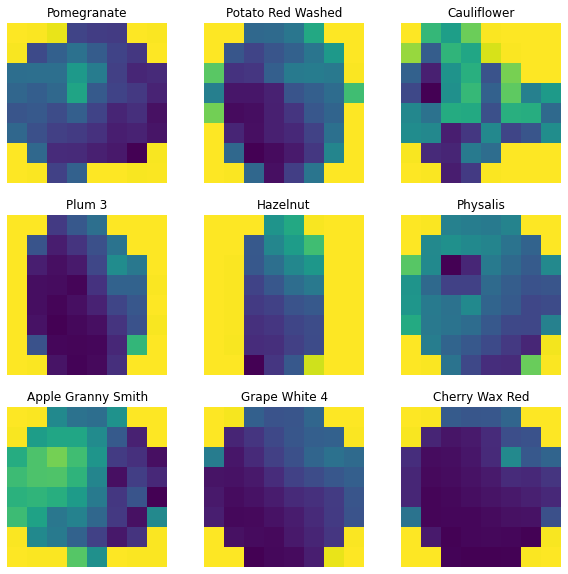

In [8]:
# data_dir = "./fruits360"
split_seed = 123
image_size = (8, 8)
validation_split=0.2
color_mode="grayscale"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./fruits-360/Training",
    # validation_split=validation_split,
    # subset="training",
    seed=split_seed,
    image_size=image_size,
    color_mode=color_mode
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./fruits-360/Test",
    # validation_split=validation_split,
    # subset="validation",
    seed=split_seed,
    image_size=image_size,
    color_mode=color_mode
)
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
# Performance tuning
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

classical_model = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1/255, input_shape=image_size),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.Flatten(),
    layers.Dense(8, activation="relu"),
    layers.Dense(2)
])

classical_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

classical_model.summary()

TypeError: __init__() missing 1 required positional argument: 'kernel_size'

In [7]:
class CircuitLayerBuilder:
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(*image_size)
    readout = cirq.GridQubit.rect(8, 1)
    circuit = cirq.Circuit()

    # TODO

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    for qubit in readout:
        circuit.append(cirq.H(qubit))

    return circuit, cirq.Z(readout)

model_circuit, model_readout = create_quantum_model()

SVGCircuit(model_circuit)

TypeError: unhashable type: 'list'

In [ ]:
quantum_model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
classical_model.fit(train_ds.)

# TODO